In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.5f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
# hay varias features que todavia no se usan
dtype_={'building_id':'int32',
        'geo_level_1_id':'int8',
        'geo_level_2_id':'int16',
        'geo_level_3_id':'int16',
        'count_floors_pre_eq':'int8',
        'age':'int16',
        'area_percentage':'int8',
        'height_percentage':'int8',
        'land_surface_condition':'category',
        'foundation_type':'category',
        'roof_type':'category',
        'ground_floor_type':'category',
        'other_floor_type':'category',
        'has_superstructure_adobe_mud':'int8',
        'has_superstructure_mud_mortar_stone':'int8',
        'has_superstructure_stone_flag':'int8',
        'has_superstructure_cement_mortar_stone':'int8',
        'has_superstructure_mud_mortar_brick':'int8',
        'has_superstructure_cement_mortar_brick':'int8',
        'has_superstructure_timber':'int8',
        'has_superstructure_bamboo':'int8',
        'has_superstructure_rc_non_engineered':'int8',
        'has_superstructure_rc_engineered':'int8',
        'has_superstructure_other':'int8'}

train_values=pd.read_csv('train_values.csv',dtype=dtype_)
train_labels=pd.read_csv('train_labels.csv',dtype={'building_id':'int32','damage_grade':'int8'})

test_values=pd.read_csv('test_values.csv',dtype=dtype_)

# Aca hago mean encoding, mode(moda) encoding y uno mas que es la suma de los 2.

In [3]:
foundation_dict={'i':0,'w':1,'u':2,'h':3,'r':4}
other_floor_dict={'s':0,'j':1,'q':2,'x':2}

def get_features(features):
    short=features.loc[:,['building_id','geo_level_1_id','geo_level_2_id','geo_level_3_id','foundation_type',\
                          'age','roof_type','ground_floor_type','other_floor_type','count_floors_pre_eq',\
                          'height_percentage','area_percentage']\
                           +[col for col in features.columns if col.startswith('has_superstructure')]]
    short['height_to_area_rt']=short['height_percentage']/short['area_percentage']

    # Encodeo las variables categóricas así porque en el TP1 parecían ser las que más peso tenían sobre damage_grade
    short.other_floor_type=short.agg({'other_floor_type':lambda x:other_floor_dict[x]})
    short.foundation_type=short.agg({'foundation_type':lambda x:foundation_dict[x]})
    short.roof_type=short['roof_type']=='x'
    short.ground_floor_type=short['ground_floor_type']=='v'
    return short

In [4]:
short_train=get_features(train_values)
short_train=short_train.merge(train_labels)
short_train=short_train.set_index('building_id')
X, y = short_train.iloc[:,:-1],short_train.iloc[:,-1]

In [41]:
params={'objective':['multi:softprob'],
        'tree_method':['exact'],
        'max_depth'        :[8],
        'learning_rate'    :[0.178],
        'gamma'            :[1e-3],
        'lambda'           :[0.95],
        'n_estimators'     :[500],
        'colsample_bytree' :[0.7],
        'colsample_bynode':[0.5]
       }

xgb_grid=GridSearchCV(estimator=xgb.XGBClassifier(),
                      param_grid=params,
                      cv=3,
                      n_jobs=2,
                      scoring=make_scorer(f1_score,average='micro'))
xgb_grid.fit(X,y)

[19:08:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=2,
             param_grid={'colsample_bynode': [0.5

# Comenzamos con 3-Fold Cross validation

In [13]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_single_precision_histogram,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,69.17116,9.65704,1.37390,0.04929,0.33340,0.24000,5,200,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'learning_rate': ...",0.75512,0.75559,0.75816,0.75629,0.00134,2
1,61.56258,4.04221,1.31837,0.10461,0.33340,0.26000,5,200,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'learning_rate': ...",0.75580,0.75612,0.75754,0.75649,0.00076,1
2,70.97805,12.65992,1.35842,0.09711,0.33340,0.28000,5,200,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'learning_rate': ...",0.75526,0.75545,0.75707,0.75593,0.00081,3
3,73.95369,10.63967,1.40163,0.12524,0.33340,0.30000,5,200,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'learning_rate': ...",0.75510,0.75491,0.75711,0.75571,0.00100,4


In [16]:
pd.DataFrame(xgb_grid.cv_results_).sort_values('rank_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_early_stopping_rounds,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_single_precision_histogram,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,77.28618,10.09020,1.18813,0.00782,0.25000,10,0.00120,0.18000,4,250,multi:softprob,True,hist,"{'colsample_bytree': 0.25, 'early_stopping_rou...",0.75469,0.75462,0.75634,0.75522,0.00079,18
6,73.25367,8.70490,1.23147,0.01683,0.25000,10,0.00120,0.26500,4,250,multi:softprob,True,hist,"{'colsample_bytree': 0.25, 'early_stopping_rou...",0.75474,0.75462,0.75651,0.75529,0.00086,17
3,74.98272,6.15512,1.23141,0.02178,0.25000,10,0.00120,0.22000,4,250,multi:softprob,True,hist,"{'colsample_bytree': 0.25, 'early_stopping_rou...",0.75500,0.75445,0.75647,0.75531,0.00085,16
9,75.69779,2.37582,1.24774,0.01324,0.33340,10,0.00120,0.18000,4,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75502,0.75561,0.75680,0.75581,0.00074,15
1,87.87714,10.97396,1.62853,0.03013,0.25000,10,0.00120,0.18000,5,250,multi:softprob,True,hist,"{'colsample_bytree': 0.25, 'early_stopping_rou...",0.75541,0.75532,0.75694,0.75589,0.00074,14
12,74.24096,16.11846,1.24517,0.03117,0.33340,10,0.00120,0.22000,4,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75565,0.75524,0.75715,0.75601,0.00082,13
4,83.47488,0.51203,1.62184,0.07637,0.25000,10,0.00120,0.22000,5,250,multi:softprob,True,hist,"{'colsample_bytree': 0.25, 'early_stopping_rou...",0.75510,0.75543,0.75753,0.75602,0.00108,12
7,81.32543,7.49541,1.59626,0.05787,0.25000,10,0.00120,0.26500,5,250,multi:softprob,True,hist,"{'colsample_bytree': 0.25, 'early_stopping_rou...",0.75535,0.75549,0.75741,0.75608,0.00094,11
15,73.66400,3.61329,1.21833,0.02531,0.33340,10,0.00120,0.26500,4,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75533,0.75518,0.75778,0.75609,0.00119,10
13,84.75633,7.10005,1.60121,0.00549,0.33340,10,0.00120,0.22000,5,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75597,0.75579,0.75749,0.75642,0.00076,9


In [18]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_early_stopping_rounds,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_single_precision_histogram,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,98.24406,1.22173,2.31331,0.21369,0.33340,10,0.00120,0.25500,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75510,0.75684,0.75763,0.75652,0.00106,6
1,93.66829,3.80516,1.92891,0.10449,0.33340,10,0.00120,0.27500,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75609,0.75704,0.75815,0.75709,0.00084,3
2,97.30558,12.50783,2.02057,0.08573,0.33340,10,0.00120,0.29000,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.3334, 'early_stopping_r...",0.75596,0.75656,0.75772,0.75675,0.00073,5
3,93.23666,9.18908,2.13301,0.03012,0.40000,10,0.00120,0.25500,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.4, 'early_stopping_roun...",0.75547,0.75693,0.75855,0.75698,0.00126,4
4,98.18707,13.30609,2.04760,0.05667,0.40000,10,0.00120,0.27500,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.4, 'early_stopping_roun...",0.75603,0.75695,0.75840,0.75713,0.00098,2
5,99.06266,12.36984,2.01010,0.62102,0.40000,10,0.00120,0.29000,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.4, 'early_stopping_roun...",0.75620,0.75743,0.75799,0.75721,0.00075,1


# Pasamos a 4-Fold para tener resultados más precisos

In [30]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_single_precision_histogram,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,119.08465,0.96739,1.67894,0.06556,0.33334,0.00150,0.19000,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.33334, 'gamma': 0.0015,...",0.75663,0.75655,0.75693,0.75845,0.75714,0.00077,3
1,121.81689,7.54940,2.27708,0.41349,0.33334,0.00150,0.20000,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.33334, 'gamma': 0.0015,...",0.75667,0.75725,0.75728,0.75902,0.75756,0.00088,2
2,121.35537,3.94744,1.73795,0.05199,0.33334,0.00150,0.21000,6,250,multi:softprob,True,hist,"{'colsample_bytree': 0.33334, 'gamma': 0.0015,...",0.75667,0.75727,0.75751,0.75906,0.75763,0.00088,1


# Probamos nuevos hiperparámetros

In [14]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_bin,param_max_depth,param_n_estimators,param_objective,param_single_precision_histogram,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,256.23219,2.83262,7.14520,0.00695,0.33334,0.00050,0.18000,512,8,500,multi:softprob,True,hist,"{'colsample_bytree': 0.33334, 'gamma': 0.0005,...",0.73703,0.74056,0.74013,0.73924,0.00157,1
1,256.90556,1.79928,6.88576,0.21528,0.33334,0.00050,0.23000,512,8,500,multi:softprob,True,hist,"{'colsample_bytree': 0.33334, 'gamma': 0.0005,...",0.73733,0.73980,0.74059,0.73924,0.00139,2


# Empezamos a usar tree_method='exact'

In [35]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bynode,param_colsample_bytree,param_gamma,param_lambda,param_learning_rate,...,param_n_estimators,param_objective,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,522.53259,5.81826,7.98293,0.47911,0.00100,0.50000,0.70000,0.00100,0.95000,0.08000,...,500,multi:softprob,exact,"{'alpha': 0.001, 'colsample_bynode': 0.5, 'col...",0.73741,0.73988,0.73989,0.73906,0.00116,3
1,528.48046,12.88004,7.21060,0.31176,0.00100,0.50000,0.70000,0.00100,0.95000,0.10000,...,500,multi:softprob,exact,"{'alpha': 0.001, 'colsample_bynode': 0.5, 'col...",0.73827,0.74026,0.74017,0.73956,0.00092,2
2,389.62573,185.70763,6.88693,2.18528,0.00100,0.50000,0.70000,0.00100,0.95000,0.14000,...,500,multi:softprob,exact,"{'alpha': 0.001, 'colsample_bynode': 0.5, 'col...",0.74056,0.74334,0.74226,0.74205,0.00115,1


In [40]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bynode,param_colsample_bytree,param_gamma,param_lambda,param_learning_rate,...,param_n_estimators,param_objective,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,488.61131,5.31938,6.96185,0.34979,0.00100,0.50000,0.70000,0.00100,0.95000,0.17000,...,500,multi:softprob,exact,"{'alpha': 0.001, 'colsample_bynode': 0.5, 'col...",0.74057,0.74329,0.74190,0.74192,0.00111,1
1,484.58342,2.68002,5.66486,1.58101,0.00100,0.50000,0.70000,0.00100,0.95000,0.19000,...,500,multi:softprob,exact,"{'alpha': 0.001, 'colsample_bynode': 0.5, 'col...",0.74026,0.74232,0.74273,0.74177,0.00108,2


In [42]:
pd.DataFrame(xgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bynode,param_colsample_bytree,param_gamma,param_lambda,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,468.26619,81.29924,6.78142,2.07932,0.50000,0.70000,0.00100,0.95000,0.17800,8,500,multi:softprob,exact,"{'colsample_bynode': 0.5, 'colsample_bytree': ...",0.74018,0.74190,0.74186,0.74131,0.00080,1


# Encontramos un buen modelo, lo entrenamos con todos los datos

In [5]:
xgb_cls=xgb.XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                          tree_method='exact',
                          max_depth=8,
                          learning_rate=0.178,
                          gamma=1e-3,
                          reg_lambda=0.95,
                          reg_alpha=1e-3,
                          n_estimators=500,
                          colsample_bytree=0.7,
                          colsample_bynode=0.5)
xgb_cls.fit(X,y)
f1_score(y, xgb_cls.predict(X), average='micro')

0.8068349699348812

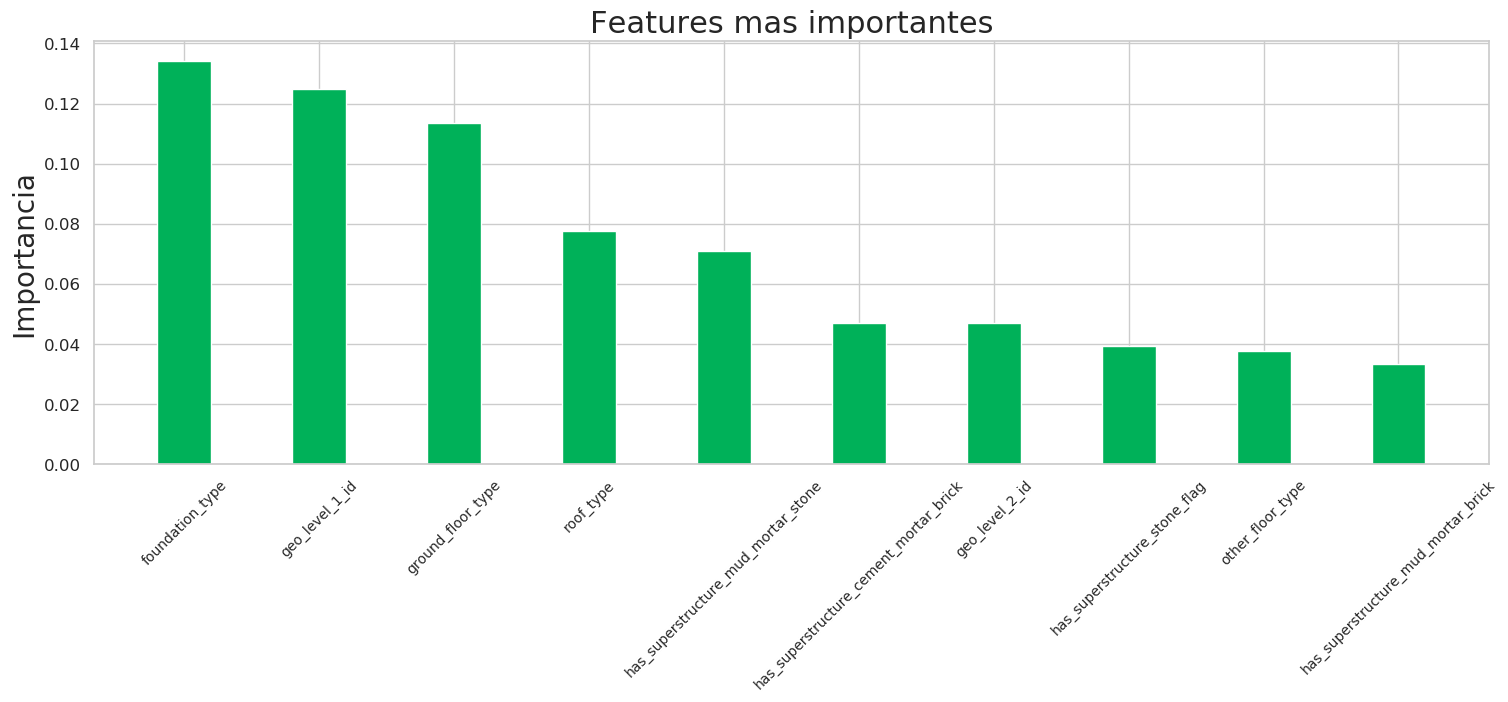

In [12]:
###grafico de features mas importantes para el modelo
###a zip pasarle array las columnas del set de train
###y array de feature importances
top_10=sorted(zip(X.columns,xgb_cls.feature_importances_),key=lambda x:x[1],reverse=True)[:10]
#paso a lista para graficar
features_names = [x[0] for x in top_10]
feature_importances = [x[1] for x in top_10]

#estilizo el bar plot
plt.figure(figsize = (18, 5.5)) 
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)
plt.bar(features_names, feature_importances, color ='#00b159', width = 0.4)
plt.title("Features mas importantes", fontsize=22)
plt.ylabel("Importancia", fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [6]:
submission_format=pd.read_csv('submission_format.csv',index_col='building_id')
submission = pd.DataFrame(data=xgb_cls.predict(get_features(test_values).set_index('building_id')),
                          columns=submission_format.columns,
                          index=submission_format.index)
submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [7]:
submission.to_csv('submissions/submission11.csv')
!head submissions/submission11.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
